In [29]:
import glob
import pandas as pd
import numpy as np
from p_tqdm import p_map
from itertools import groupby
import sys
patterns=["/*Spots_Position*","/*_Speed.csv",
         "/*_Track_Speed_Max*","/*_Track_Speed_Mean*","/*_Track_Length*","/*Track_Displacement_Length*"]
scale_table=pd.read_csv('conversion_final.csv')
scale_table.file=[spe.split('_', 1)[1] for spe in scale_table.file]

# functions to process the tracks info
def gather_inaris(fls):
    
    dataset=pd.read_csv(fls[0],skiprows=3)
    sample=fls[0].split('/')[2]
    
    
  
    Imaris_distance=scale_table[scale_table['file']==sample]['imaris_µm'].to_list()[0]
    real_distance=scale_table[scale_table['file']==sample]['irl_µm'].to_list()[0]
    sc=real_distance/Imaris_distance
    
    
    if any(dataset.columns=="ID"):    
            dataset = dataset[dataset['ID'].notna()]
            dataset['Parent'] = dataset["ID"]
            
    if any(dataset.columns=="TrackID"): 
            dataset['Parent'] = dataset["TrackID"]
            dataset = dataset[dataset['Parent'].notna()]
    
    
    sample_name=sample
     
    if any(dataset.columns=="Parent"):    
            dataset['Parent']=[sample_name+'_'+str(name) for name in np.array(dataset['Parent'])] 
            
        
    if any(dataset.columns=="Track Speed Max"):
        dataset.loc[:,["Track Speed Max"]]=dataset.loc[:,["Track Speed Max"]]*sc
    
    elif any(dataset.columns=="Track Speed Mean"):
        dataset.loc[:,["Track Speed Mean"]]=dataset.loc[:,["Track Speed Mean"]]*sc
    elif any(dataset.columns=="Speed"):
        dataset.loc[:,["Speed"]]=dataset.loc[:,["Speed"]]*sc
    elif any(dataset.columns=="Track Length"):
        dataset.loc[:,["Track Length"]]=dataset.loc[:,["Track Length"]]*sc        
    elif any(dataset.columns=="Track Displacement Length"):
        dataset.loc[:,["Track Displacement Length"]]=dataset.loc[:,["Track Displacement Length"]]*sc    
    else:
        try:
            dataset.loc[:,["Position X","Position Y"]]=dataset.loc[:,["Position X","Position Y"]]*sc  
        except:
            print(sample)
       
            
    return dataset

def imaris_to_csv(fold):   
        
    filesets=list(map(lambda x: glob.glob(fold+x),patterns))
    #print(filesets)
    datasets=list(map(gather_inaris,filesets))
    
    data_tracks, data_speeds, data_maxspeeds, data_meanspeeds, data_tracks_length, data_displacement = datasets[0], datasets[1], datasets[2], datasets[3], datasets[4], datasets[5]
    data_tracks.to_csv(fold+"/all_tracks_converted.csv")
    data_speeds.to_csv(fold+"/all_speeds_converted.csv")
    data_maxspeeds.to_csv(fold+"/all_maxspeeds_converted.csv")
    data_meanspeeds.to_csv(fold+"/all_meanspeeds_converted.csv")
    data_tracks_length.to_csv(fold+"/all_tracks_length_converted.csv")
    data_displacement.to_csv(fold+"/all_tracks_displacement_length_converted.csv")
    


In [19]:
path='datasets'
folds=glob.glob(path+"/*/*")

In [20]:
for fold in folds:
    imaris_to_csv(fold)

In [21]:
sample=list(map(lambda x: x.split("/")[1],glob.glob("datasets/*")))
vectorized=list()
paths=list()
for n,samp in enumerate(sample):
    path = 'datasets/'+samp
    files = [f for f in glob.glob(path + "/*Position.csv", recursive=False) if 'Track' not in f]
    
    for i in range(len(files)):
        sp=samp.split('_')[1]
        species=sp.split('.')[0]+'_'+sp.split('.')[1]
        if species.endswith('_virids'):
            species='corynactis_viridis'
        
        vectorized.append([samp,species,n, files[0]])
        paths.append(files[0])


# Start processing

In [22]:
species=list(map(lambda x: x.split("/")[1],glob.glob("datasets/*/")))
vectorized=list()
for spe in species:
    path = 'datasets/'+spe
    files = [f for f in glob.glob(path + "/*/all_tracks_converted.csv", recursive=True)]
    for i in files:
        vectorized.append([spe,i])



In [31]:
numcores=21

def gather_dat(vector):
    from helpers import track_tools, line_intersection3
    spe=vector[0]    
    path = 'datasets/'+spe
    sample=vector[1].split('/')[2]
    rep=sample.split('_')[1]
    
    fps=scale_table[scale_table['file']==sample]['fps'].to_list()[0]
    

    sc=1# conversion already done

    adata=pd.read_csv(vector[1])
    
    adata['frame']=adata['Time']
    adata['Time']=adata['Time']/fps
    
    allparents=np.unique(adata['Parent'])
    
    ldata=list(map(lambda x: adata[["Position X","Position Y","Time"]].loc[adata.index[adata["Parent"].isin([x],)]], 
                         [par for par in allparents]))
    
    
    ldata=list(map(track_tools.distances_accelerations,ldata))
    results = list(map(track_tools.sinuosities_max, ldata))
    turns=list(map(lambda y: sum([x[0] for x in groupby(y["sinuosity"]>1.1)]), results))
    sin=list(map(track_tools.sinuosities_track, ldata))
    length=list(map(lambda x: np.nansum(x["dst"]),ldata))
    npoints=list(map(lambda x: len(x["dst"]),ldata))
    speedvar=list(map(lambda x: np.nanvar(x["acc"]),ldata))
    speedmean=list(map(lambda x: np.nanmean(x["dst"]),ldata))

    lseg=list(map(lambda x: np.hstack([x.values[:-1,:2],x.values[1:,:2]]).tolist(),ldata))
    inter=list(map(lambda x: len(list(line_intersection3.line_intersections(x))),lseg))

    A=[turns,sin,length,npoints,speedmean,speedvar,inter]
    dat=pd.DataFrame(A).T
    dat.columns=["turns","sin","length","npoints","speedmean","speedvar","inter"]
    dat["rep"]=rep
    dat["specie"]=spe
    dat["Parents"]=allparents  
    return(dat)

# Process data without Speed max or length info

In [32]:
datas=[]
for n in range(len(vectorized)):
   # print(vectorized[n],n)
    d=gather_dat(vectorized[n])
        #print(d)
    datas.append(d)


/tmp/ipykernel_1342336/2361283947.py:39: RuntimeWarning: Degrees of freedom <= 0 for slice.
  speedvar=list(map(lambda x: np.nanvar(x["acc"]),ldata))


In [33]:
all_dat=pd.concat(datas)

In [34]:
all_dat.index=all_dat['Parents']

In [35]:
#Turn data into float to help further calculations
convert_dict = {'turns': float,
                'sin': float,
                'length': float,
                'npoints': float,
                'speedmean': float,
                'speedvar': float,
                'inter': float
                }
 
all_dat = all_dat.astype(convert_dict)

In [36]:
#Remove duplicates
species=all_dat["specie"]
features=["turns","sin","speedmean","speedvar","inter"]
x = all_dat.loc[:, features].values
idx_torem=(np.argwhere(np.apply_along_axis(lambda y: any(np.isnan(y)),1,x))).flatten().tolist()
#all_dat=all_dat.reset_index()
all_dat=all_dat.drop(idx_torem)
species=np.delete(species.values,idx_torem)
x=np.delete(x,idx_torem,axis=0)

KeyError: '[4165, 4171, 4184, 4215, 4216, 4225, 4227, 4233, 4236, 4259, 4265, 4266, 4278, 4281, 4304, 4306, 4310, 4340, 4344, 4359, 4360, 4364, 4369, 4378, 4396, 4400, 4412, 4423, 4425, 4433, 4434, 4464, 4488, 4494, 4511, 4518, 4524, 4528, 4542, 4546, 4551, 4553, 4575, 4591, 4600, 4604, 4605, 4613, 4614, 4617, 4641, 4643, 4654] not found in axis'

In [50]:
all_dat.dropna(inplace=True)
x = all_dat.loc[:, features].values

# Do the plotting of the tracks

In [40]:
import scanpy as sc
import matplotlib.pyplot as plt
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = ["sans-serif"]
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.bbox"] = "tight"



In [51]:
#Create the anndata object for plotting
adata=sc.AnnData(x,obs=all_dat[["specie"]])

In [52]:
#Save the table for Theres-> do it again later with all data
all_dat.to_excel('~/data/Coral/tables/Cnidarians_NO_Scler_table.xlsx')

In [53]:
#Do the calculations
adata.obs_names=all_dat['Parents']
adata.var_names=["turns","sin","speedmean","speedvar","inter"]
adata.raw=adata
sc.pp.scale(adata)
sc.pp.neighbors(adata,n_neighbors=30,metric="correlation")
sc.tl.umap(adata,min_dist=.2)
adata.obs.specie.value_counts()

agaricia.species            2175
diploria.species            1902
fungia.species              1121
exaiptasia.diaphana         1006
cassiopea.andromeda          888
cirrhipathes.species         883
tubastrea.coccinea           879
carybdea.species             596
corynactis.california        492
aiptasiogeton.species        481
cladocora.species            435
corynactis.viridis           401
zoanthus.sociatus            375
stomolophus.meleagris        223
pseudocorynactis.species     203
stichopathes.species         181
sanderia.malayensis          159
ricordea.species             112
Name: specie, dtype: int64

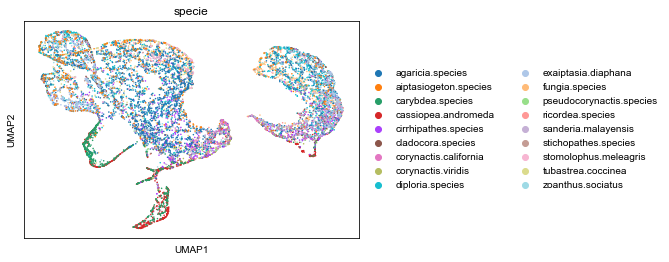

In [54]:
sc.pl.umap(adata,color="specie")

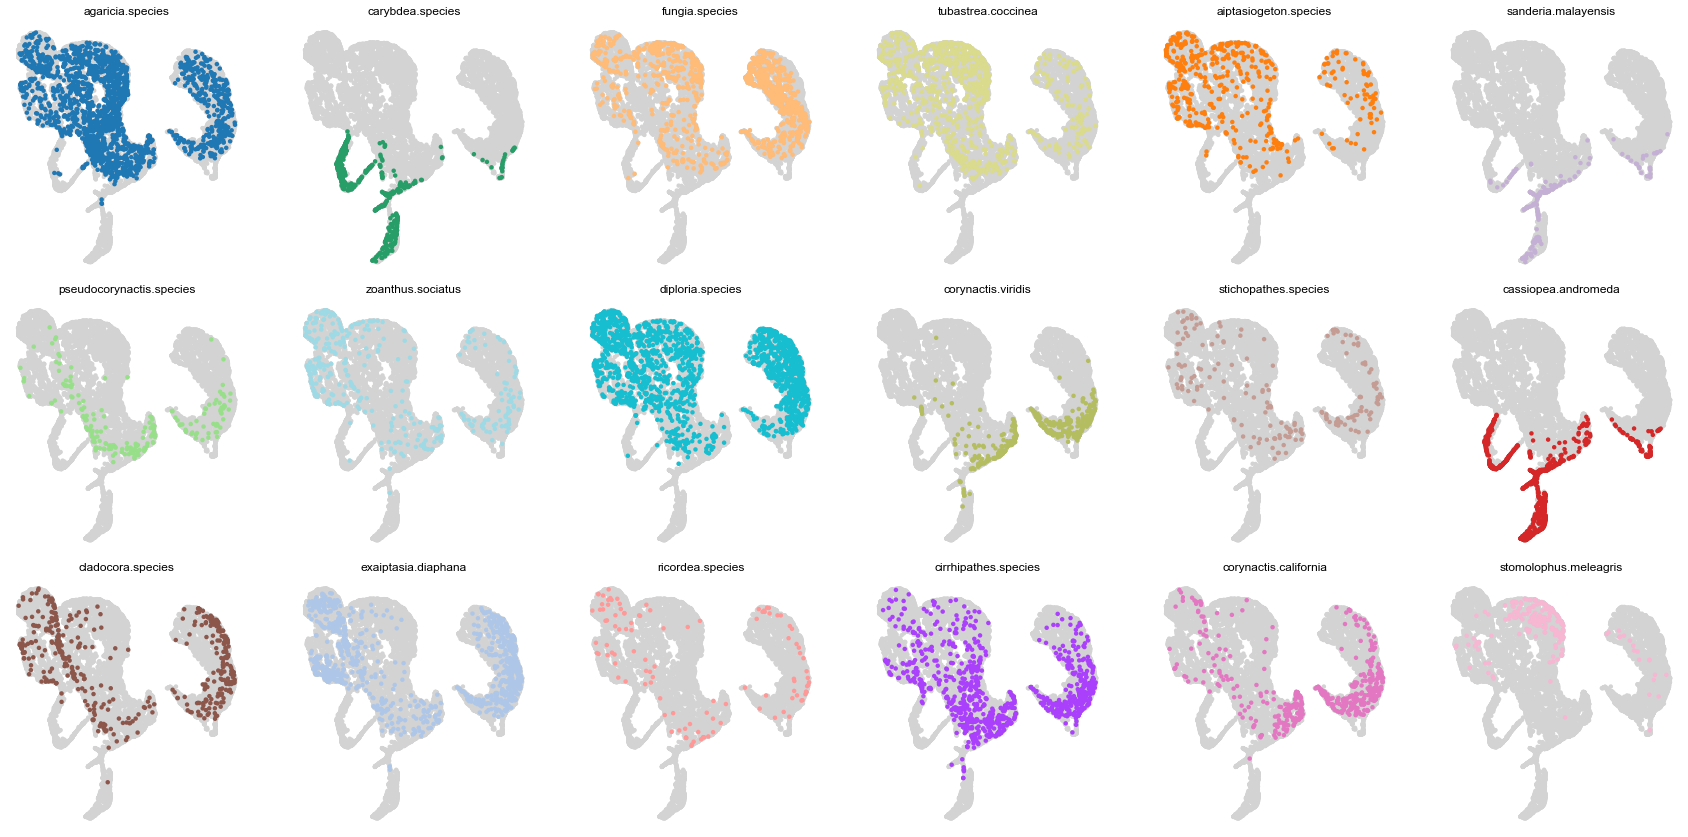

In [55]:
import math
ncol=6
nrows=math.ceil(len(list(set(adata.obs.specie)))/5)

plt.figure(figsize=(30, nrows*5))
plt.subplots_adjust(hspace=0.1, wspace=.2)

for n, species in enumerate(set(adata.obs.specie)):
    
    ax = plt.subplot(nrows, ncol, n + 1)
    
    sc.pl.umap(
    adata,
    color=None,
    show=False,
    size=80,
    frameon=False,
    ax=ax)
    
    sc.pl.umap(
    adata[adata.obs.specie == species],
    color="specie",
    size=80,
    show=False,
    frameon=False,
    legend_fontsize=20,
    ax=ax,
    title=species)
    
    ax.legend_ = None

#plt.savefig(save_path+'embeddings/'+face+'_W11-5_SPREAD_deconvolution_spatial',dpi=150)

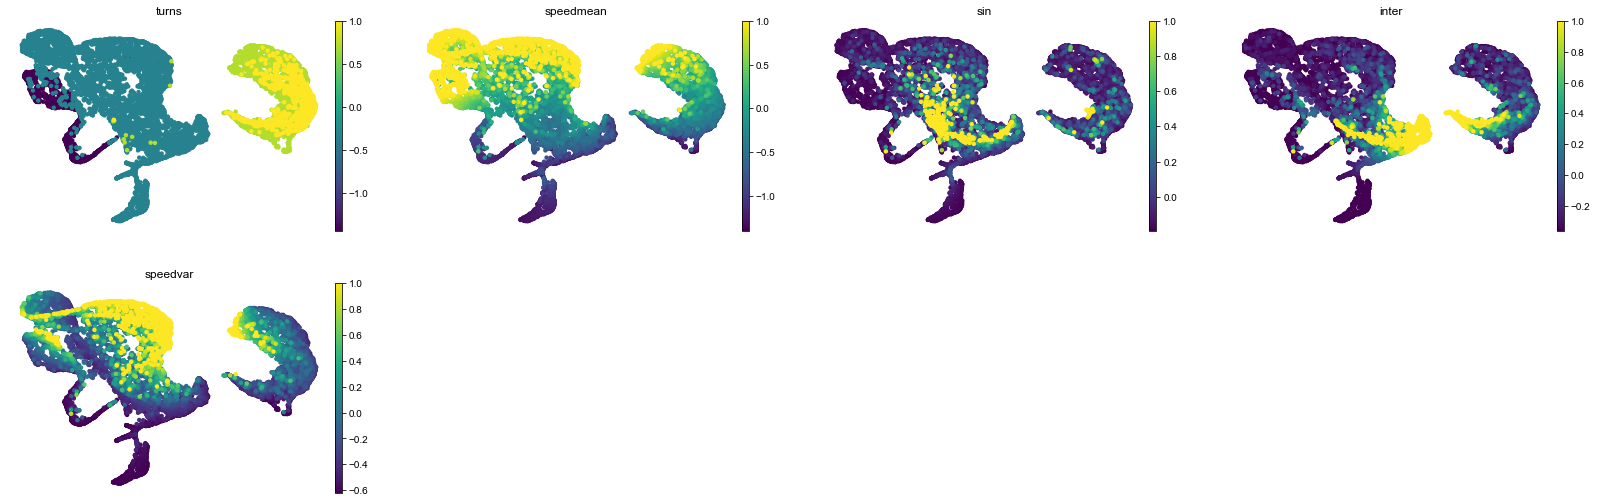

In [56]:
sc.pl.umap(adata,color=list(set(adata.var_names)),size=80,frameon=False,
           vmax=1
          )

In [57]:
adata.write_h5ad('~/data/Coral/H5ADs/Cnidarians_No_Scler_tracks_Not_full.h5ad')

In [58]:
sc.read('~/data/Coral/H5ADs/Cnidarians_No_Scler_tracks_Not_full.h5ad')

AnnData object with n_obs × n_vars = 12512 × 5
    obs: 'specie'
    var: 'mean', 'std'
    uns: 'neighbors', 'specie_colors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

#### Open all the speed max files for non Sclec cnidarians

In [59]:
species=list(map(lambda x: x.split("/")[1],glob.glob("datasets/*/")))
vectorized=list()
for spe in species:
    path = 'datasets/'+spe
    files = [f for f in glob.glob(path + "/*", recursive=True)]
    for i in files:
        vectorized.append(i)


In [60]:
#scale_table=pd.read_csv('conversion_final.csv')

patterns=["/all_maxspeeds_converted*","/all_tracks_length_converted*","/all_tracks_displacement_length_converted*"]

def get_additional_data(path):    
        
    sample=path[0].split('/')[2]
    
    fps=scale_table[scale_table['file']==sample]['fps'].to_list()[0]  

    
    df=pd.read_csv(path[0])    
    
    if any(df.columns=="Track Speed Max"):
        df.loc[:,["Track Speed Max"]]=df.loc[:,["Track Speed Max"]]*fps
        df=df[['Track Speed Max', 'Parent']]
        df.index= df['Parent']
        df=pd.DataFrame(df['Track Speed Max'])
        
    elif any(df.columns=="Track Length"):
                
        df=df[['Track Length', 'Parent']]
        df.index= df['Parent']
        df=pd.DataFrame(df['Track Length'])
        
    elif any(df.columns=="Track Displacement Length"):
            
        df=df[['Track Displacement Length', 'Parent']] 
        df.index= df['Parent']
        df=pd.DataFrame(df['Track Displacement Length'])  
   
    return df

    
def additional_data(fold):   
    filesets=list(map(lambda x: glob.glob(fold+x),patterns))    
    datasets=list(map(get_additional_data,filesets))    
     
    ad=pd.concat(datasets,axis=1)
    return ad

In [61]:
adddatas=[]
for n in range(len(vectorized)):    
    d=additional_data(vectorized[n])    
    adddatas.append(d)

add_datas_concat=pd.concat(adddatas)

In [62]:
#Remove 0s at the end of the indices
all_dat.index=[item[0] for item in all_dat.index.str.split('[.]0')]

In [63]:
aller_dat=pd.concat([all_dat,add_datas_concat],axis=1)

convert_dict = {'turns': float,
                'sin': float,
                'length': float,
                'npoints': float,
                'speedmean': float,
                'speedvar': float,
                'inter': float,
                'Track Speed Max': float,
                'Track Length': float,
                'Track Displacement Length': float
                
                }
 
aller_dat = aller_dat.astype(convert_dict)

aller_dat=aller_dat.drop(labels=['rep', 'Parents'], axis=1)
aller_dat=aller_dat.dropna()

In [64]:
aller_dat.to_excel('~/data/Coral/tables/Cnidarian_NO_SCLER_tracks_properties.xlsx')

In [65]:
species=aller_dat["specie"]
features=["turns","sin","speedmean","speedvar","inter",'length','Track Speed Max','Track Displacement Length']
x = aller_dat.loc[:, features].values


ad=sc.AnnData(x,obs=aller_dat[["specie"]])

In [66]:
ad.obs_names=aller_dat.index
ad.var_names=features
ad.raw=ad
sc.pp.scale(ad)
sc.pp.neighbors(ad,n_neighbors=30,metric="correlation")
sc.tl.umap(ad,min_dist=.2)
ad.obs.specie.value_counts()

agaricia.species            2175
diploria.species            1902
fungia.species              1121
exaiptasia.diaphana         1006
cassiopea.andromeda          888
cirrhipathes.species         883
tubastrea.coccinea           879
carybdea.species             596
corynactis.california        492
aiptasiogeton.species        481
cladocora.species            435
corynactis.viridis           401
zoanthus.sociatus            375
stomolophus.meleagris        223
pseudocorynactis.species     203
stichopathes.species         181
sanderia.malayensis          159
ricordea.species             112
Name: specie, dtype: int64

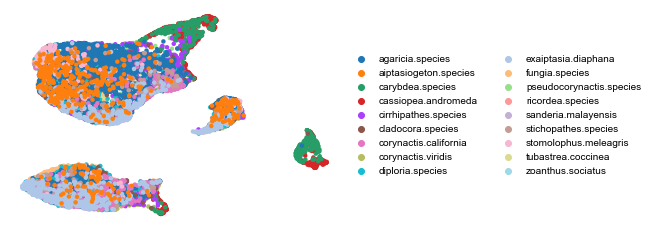

In [67]:
ax = plt.subplot(1,1,1)
sc.pl.umap(
    ad,
    color="specie",
    size=80,
    show=False,
    ax=ax,
    frameon=False,
    legend_fontsize=10,
    title='')
plt.savefig('~/data/Coral/exports/paper/UMAP_ALL_species.svg', bbox_inches="tight")

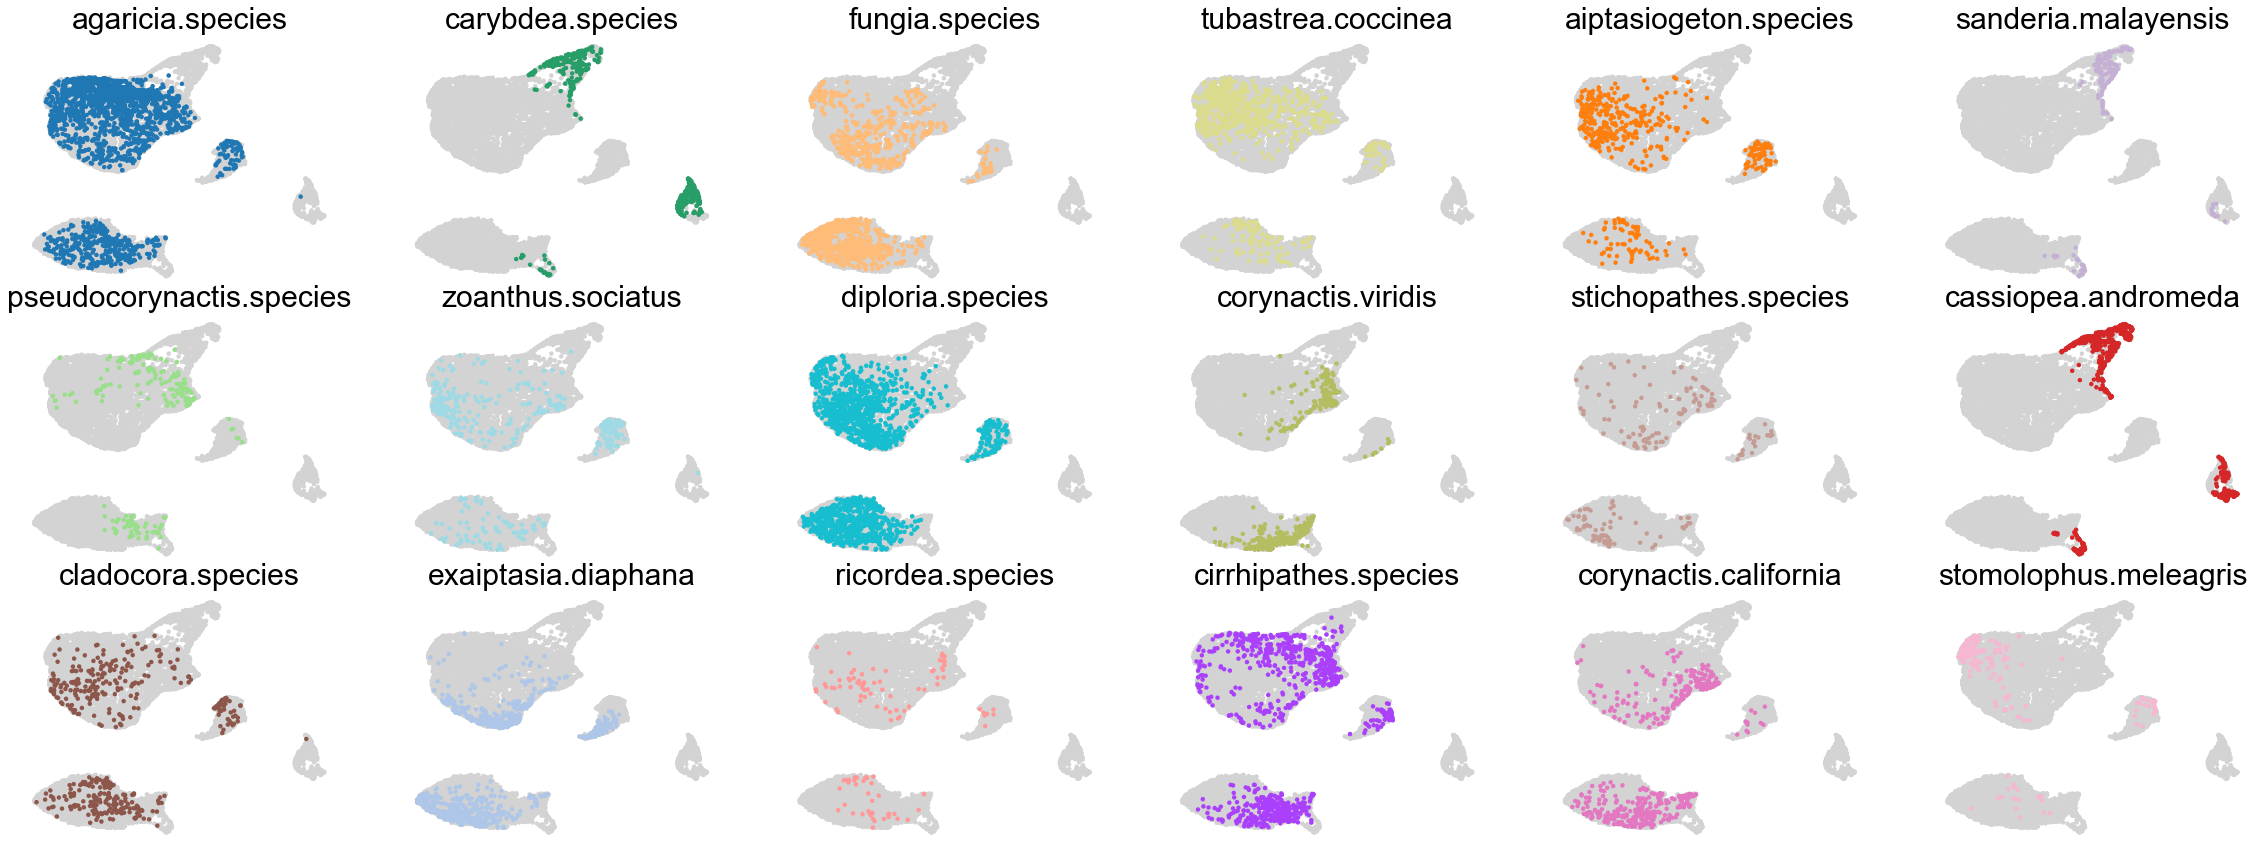

In [68]:
import math
ncol=6
nrows=math.ceil(len(list(set(ad.obs.specie)))/5)
#fig, ax = plt.subplots(figsize=(ncol*5, nrows*5))
plt.figure(figsize=(40, nrows*5))
plt.subplots_adjust(hspace=0.1, wspace=.2)

for n, species in enumerate(set(ad.obs.specie)):
    
    ax = plt.subplot(nrows, ncol, n + 1)
    
    sc.pl.umap(
    ad,
    color=None,
    show=False,
    size=80,
    frameon=False,
    ax=ax)
    
    sc.pl.umap(
    ad[ad.obs.specie == species],
    color="specie",
    size=80,
    show=False,
    frameon=False,
    legend_fontsize=40,
    ax=ax,
    title=species)
    ax.title.set_size(30)
    ax.legend_ = None

plt.savefig('~/data/Coral/exports/paper/UMAP_Split_species.svg', bbox_inches="tight")

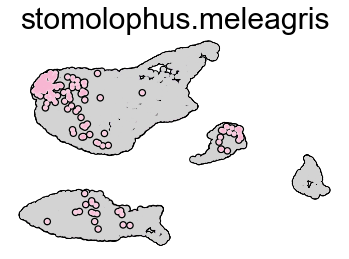

In [69]:
import math
ncol=6
nrows=math.ceil(len(list(set(ad.obs.specie)))/5)
#fig, ax = plt.subplots(figsize=(ncol*5, nrows*5))
#plt.figure(figsize=(40, nrows*5))
#plt.subplots_adjust(hspace=0.1, wspace=.2)

for n, species in enumerate(set(ad.obs.specie)):
    
    ax = plt.subplot(1, 1, 1)
    
    sc.pl.umap(
    ad,
    color=None,
    show=False,
    size=80,
    frameon=False,
    ax=ax)
    
    sc.pl.umap(
    ad[ad.obs.specie == species],
    color="specie",
    size=80,
    show=False,
    frameon=False,
    add_outline=True,
    legend_fontsize=20,
    ax=ax,
    title=species)
    ax.title.set_size(30)
    ax.legend_ = None

    plt.savefig('~/data/Coral/exports/paper/UMAP_Split_'+species+'_Outlined.svg', bbox_inches="tight")

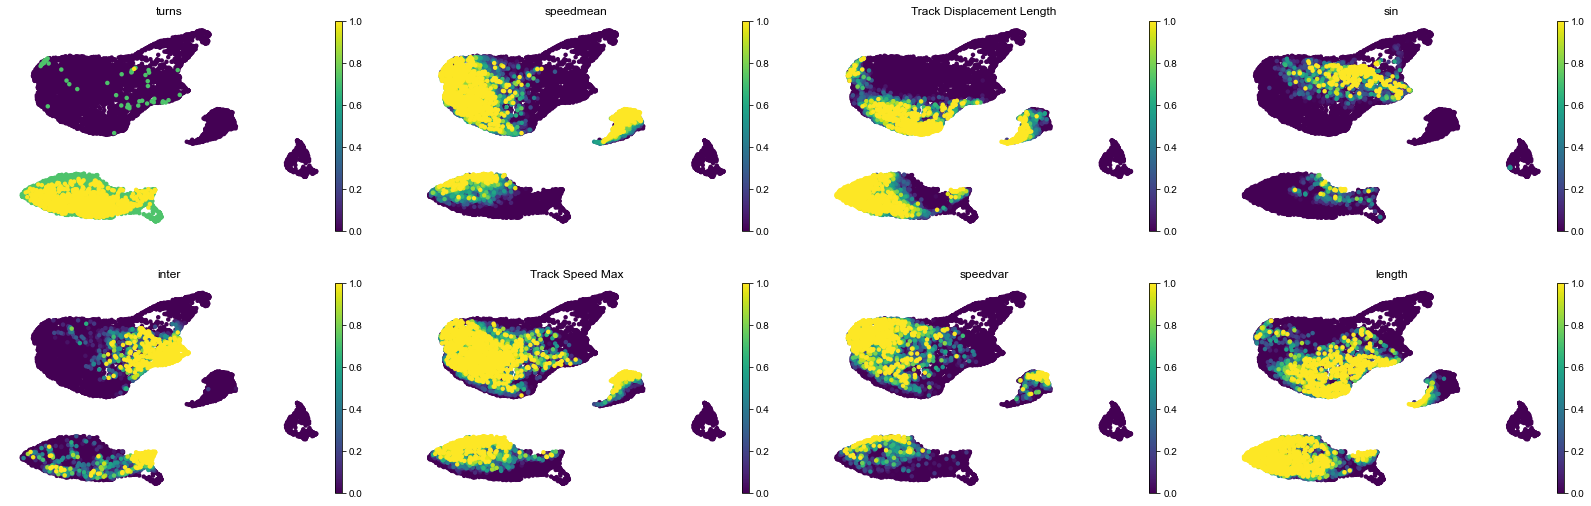

In [70]:
sc.pl.umap(ad,color=list(set(ad.var_names)),size=80,frameon=False,show=False,
           vmax=1, vmin=0
          )
plt.savefig('~/data/Coral/exports/paper/UMAP_split_Parameters.svg', bbox_inches="tight")

In [71]:
ad.write_h5ad('~/data/Coral/H5ADs/Cnidarians_NO_SCLER_all_properties.h5ad')

In [72]:
ad=sc.read_h5ad('~/data/Coral/H5ADs/Cnidarians_NO_SCLER_all_properties.h5ad')

# Calculate the percentage of each cluster in the species

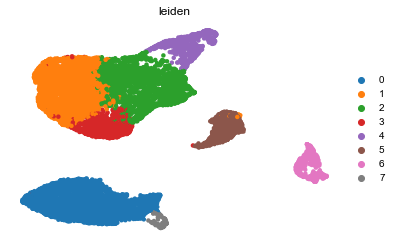

In [73]:
sc.tl.leiden(ad, resolution=.2)
#sc.pl.umap(ad,color='leiden',size=80,frameon=False,save='/home/tbou/data/Coral/exports/theres_thesis/271123_Leiden_Clustered_umap.svg' )



sc.pl.umap(ad,color='leiden',size=80,frameon=False,show=False )
plt.savefig('~/data/Coral/exports/paper/UMAP_Leiden_Clustered.svg', bbox_inches="tight")

In [74]:
proportions=[]
df=ad.obs

for spe in set(df['specie']):
    ls=df[df['specie']==spe]['leiden']
    props=pd.DataFrame(ls.value_counts())
    
    props=props.transpose()
    props['species']=spe
    #props.set_index(spe)
    proportions.append(props)
proportions=pd.concat(proportions,axis=0)

In [75]:
proportions.index=proportions['species']

In [76]:
proportions=proportions.reindex(columns=list(map(str, range(len(proportions.columns)-1))))

In [77]:
#Index according to clades
ordered_index=["zoanthus.sociatus",#Zoanthria
               "aiptasiogeton.species","exaiptasia.diaphana",#actinaria 
 "cirrhipathes.species","stichopathes.species", #Antipatharia
  "corynactis.california","corynactis.viridis", "pseudocorynactis.species","ricordea.species",#corallimorpharia 
    "cladocora.species","fungia.species",'agaricia.species', 'diploria.species','tubastrea.coccinea',#Scler 
 "cassiopea.andromeda","sanderia.malayensis",'stomolophus.meleagris',#discomedusae
               "carybdea.species"#cubomedusae
]

In [78]:
percentages=[]
for n in range(len(proportions.index)):
    line=proportions.iloc[n,:]
    #species=proportions.index[n]    
    total_tracks=line.sum()
    line=line.div(total_tracks).mul(100)
    d=pd.DataFrame(line)
    percentages.append(d)

percentages=pd.concat(percentages,axis=1)



In [79]:
#Reorder
percentages=percentages.T.reindex(ordered_index).T

In [80]:
import matplotlib.pyplot as plt
import numpy as np

In [81]:
percentages.to_excel('~/data/Coral/exports/theres_thesis/Percentages_tracks_species.xlsx')

/tmp/ipykernel_1342336/1263151141.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( groups,rotation=90)


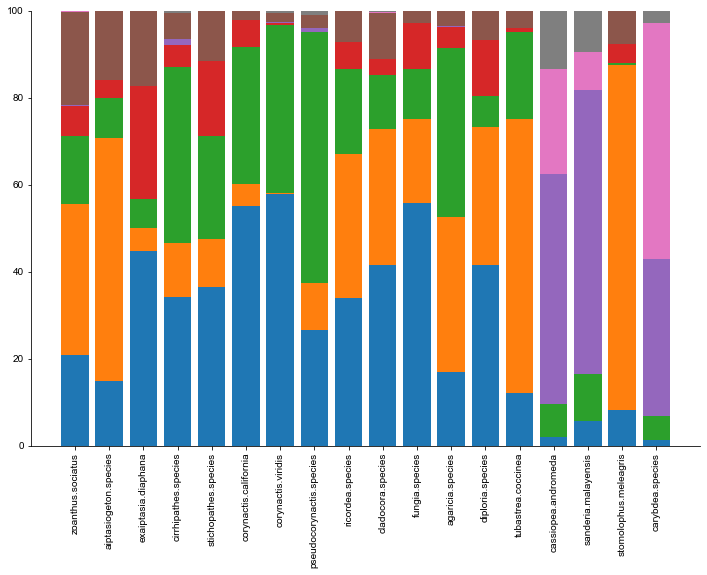

In [82]:
# Data
values = percentages.to_numpy()
groups=percentages.columns.to_list()


fig, ax = plt.subplots(figsize=(12,8))

# Stacked bar chart with loop
for i in range(values.shape[0]):
    ax.bar(groups, values[i], bottom = np.sum(values[:i], axis = 0))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(True)  

#locs, labels = plt.xticks()
ax.set_xticklabels( groups,rotation=90)

plt.savefig('~/data/Coral/exports/paper/BARPLOTS_Leiden_proportion_per_species.svg', bbox_inches="tight")

# Calculate distance between species

In [83]:
from scipy.spatial.distance import pdist
import itertools
from scipy.spatial.distance import squareform

In [84]:
perc=percentages.transpose()
#perc.index=[name.replace('.','_') for name in perc.index]

In [85]:
perc=perc.reindex(ordered_index)

In [86]:
#Get correlation matrix as classical df
d=pd.DataFrame(squareform(pdist(perc, 'cosine')), index=perc.index, columns= perc.index)

<AxesSubplot:>

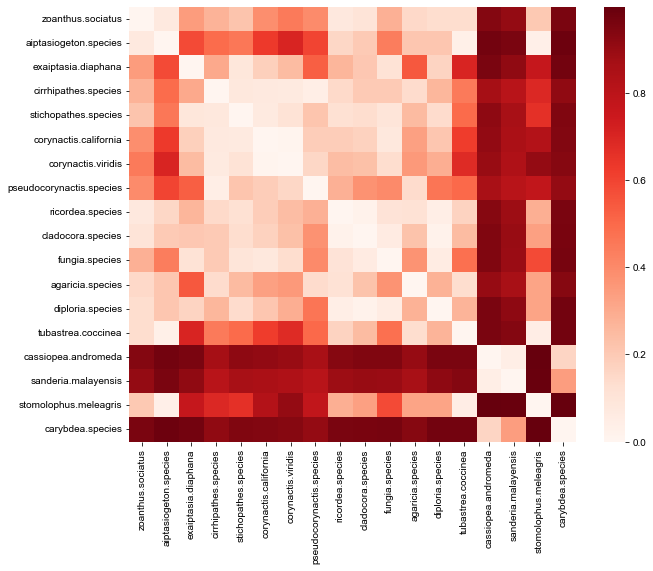

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.figure(figsize=[10,8])
sns.heatmap(
    d,cmap=plt.cm.get_cmap('Reds'),
    xticklabels=True,
    yticklabels=True)
#plt.savefig('/home/tbou/data/Coral/exports/theres_thesis/271123_Euclidean_distances_tracks_species.svg', bbox_inches="tight")#

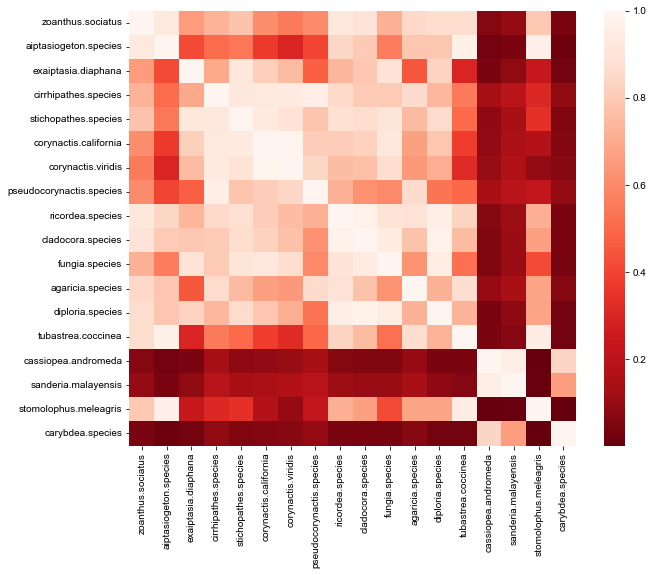

In [88]:
plt.figure(figsize=[10,8])
sns.heatmap(
   1-d,cmap=plt.cm.get_cmap('Reds').reversed(),
    xticklabels=True,
    yticklabels=True)
plt.savefig('/home/tbou/data/Coral/exports/paper/Heatmap_Euclidean_distances_tracks_species_reversed.svg', bbox_inches="tight")

In [89]:
d = pd.DataFrame(itertools.combinations(perc.index, 2), columns=['i','j'])
d['dist'] = 1-pdist(perc, 'cosine')
#d.sort_values('dist',ascending=False).head(30)

In [90]:
d.sort_values('dist',ascending=False).head(30)

,i,j,dist
75,corynactis.california,corynactis.viridis,0.990769
119,cladocora.species,diploria.species,0.979040
108,ricordea.species,cladocora.species,0.977809
28,aiptasiogeton.species,tubastrea.coccinea,0.965336
31,aiptasiogeton.species,stomolophus.meleagris,0.962800
51,cirrhipathes.species,pseudocorynactis.species,0.956727
111,ricordea.species,diploria.species,0.956191
147,cassiopea.andromeda,sanderia.malayensis,0.953941
145,tubastrea.coccinea,stomolophus.meleagris,0.951763
126,fungia.species,diploria.species,0.945290


## Prep matrix for sorting according to correlation

In [91]:
def sort_correlation_matrix(correlation_matrix):
    cor = correlation_matrix
    top_col = cor[cor.columns[2]][1:]
    top_col = top_col.sort_values(ascending=True)
    ordered_columns =  top_col.index.tolist()
    return correlation_matrix.loc[ordered_columns].reindex(ordered_columns)

<AxesSubplot:xlabel='i', ylabel='j'>

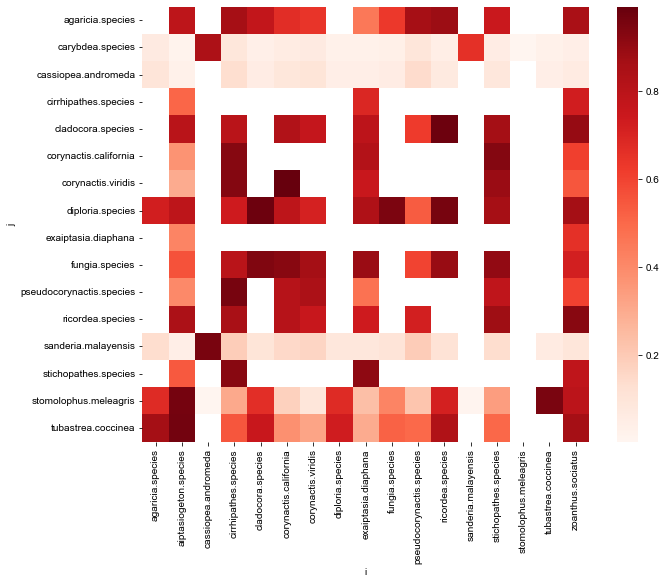

In [92]:
plt.figure(figsize=[10,8])
sns.heatmap(
    sort_correlation_matrix(d).pivot(columns='i',index='j',values='dist'),cmap=plt.cm.get_cmap('Reds'),
    xticklabels=True,
    yticklabels=True)
#plt.savefig('/home/tbou/data/Coral/exports/theres_thesis/271123_Euclidean_distances_tracks_species_sorted.svg', bbox_inches="tight")

## Do FAMD analysis

In [184]:
import prince

In [185]:
aller_dat['sample']=[sample.rsplit('_', 1)[0] for sample in aller_dat.index]
aller_dat['specie']=[species.replace('.', '_') for species in aller_dat['specie']]

In [186]:
#Calculate mean values for each category
samples=sorted(set(aller_dat['sample']))
arguments=[elements for elements in aller_dat.columns if elements not in ('specie', 'sample') ]
mean_values=pd.DataFrame(data=samples)

for arg in arguments:
    new_values=[]
    
    for sample in samples:    
        value=aller_dat[aller_dat['sample']==sample][arg].mean()
        
        new_values.append(value)
    
    to_concat=pd.DataFrame(data=new_values)
    mean_values=pd.concat([mean_values, to_concat], axis=1)

    
species=[]
for sample in samples:
    spec=list(set(aller_dat[aller_dat['sample']==sample]['specie']))[0]
    species.append(spec)

data_species=pd.DataFrame(data=species)
mean_values=pd.concat([mean_values, data_species], axis=1)

arguments.append('species')
mean_values.columns=['sample']+arguments
mean_values['nr']=mean_values.index

In [187]:
life_info=pd.read_csv('/home/tbou/data/Coral/cnidarian_Life_info.csv')

In [188]:
life_info

,nr,species,order,family,subclass,class,currents,zoox,climate,life.style,skeleton
0,1,a.manjano,Actinaria,Actiniidae,Hexacorallia,Anthozoa,absence,presence,temperate,solitary,absence
1,2,a.viridis,Actinaria,Actiniidae,Hexacorallia,Anthozoa,absence,presence,temperate,solitary,absence
2,3,aiptasiogeton_species,Actinaria,Aiptasiidae,Hexacorallia,Anthozoa,presence,absence,temperate,solitary,absence
3,4,anthopleura.elegantissima,Actinaria,Actiniidae,Hexacorallia,Anthozoa,absence,presence,temperate,solitary,absence
4,28,cassiopea_andromeda,Rhizostomeae,Cassiopeidae,Discomedusae,Scyphozoa,presence,presence,temperate,solitary,absence
5,16,cerianthus.sp,Spirularia,Cerianthidae,Ceriantharia,Anthozoa,absence,absence,temperate,solitary,absence
6,6,cirripathes_species,Antipatharia,Antipathidae,Hexacorallia,Anthozoa,presence,presence,tropical,colonial,presence
7,8,cladocora_species,Scleractinia,Cladocoridae,Hexacorallia,Anthozoa,presence,presence,temperate,colonial,presence
8,23,cladonema.sp,Anthoathecata,Cladonematidae,Hydroidolina,Hydrozoa,absence,absence,temperate,solitary,absence
9,10,corynactis_california,Corallimorpharia,Corallimorphidae,Hexacorallia,Anthozoa,presence,absence,temperate,solitary,absence


In [189]:
#Add categorical values

cols=[elements for elements in life_info.columns if elements not in  ('nr','species') ]
characteristics=pd.DataFrame()
for spec in mean_values['species']:
    category_values=[]
    for col in cols:
        value=list(set(life_info[life_info['species']==spec][col]))[0]
        category_values.append(value)
    to_concat=pd.DataFrame(data=category_values)
    characteristics=pd.concat([characteristics, to_concat], axis=1)

characteristics=characteristics.T
characteristics.columns=cols
characteristics.index=range(len(characteristics))
characteristics['nr']=characteristics.index

IndexError: list index out of range

In [220]:
#Concat track info and characteristics
full_info_df=pd.merge(mean_values,characteristics,on='nr')
full_info_df.index=full_info_df['sample']
full_info_df=full_info_df.drop(columns=['nr','sample'])


In [529]:
full_info_df

,turns,sin,length,npoints,speedmean,speedvar,inter,Track Speed Max,Track Length,Track Displacement Length,species,order,family,subclass,class,currents,zoox,climate,life.style,skeleton
sample,,,,,,,,,,,,,,,,,,,,
010223_corynactis.california.1,1.577540,5.341014,1684.438776,546.085561,3.990235,11.784054,44.812834,222.138439,1684.395094,566.041502,corynactis_california,Corallimorpharia,Corallimorphidae,Hexacorallia,Anthozoa,presence,absence,temperate,solitary,absence
010223_corynactis.california.2,1.798701,1.813248,1554.533788,374.577922,6.264477,14.651707,11.551948,304.016821,1554.469829,1024.920959,corynactis_california,Corallimorpharia,Corallimorphidae,Hexacorallia,Anthozoa,presence,absence,temperate,solitary,absence
010223_corynactis.california.3,2.258278,2.027562,1562.911309,352.589404,5.072217,10.186182,8.814570,252.844012,1562.879625,957.304340,corynactis_california,Corallimorpharia,Corallimorphidae,Hexacorallia,Anthozoa,presence,absence,temperate,solitary,absence
020823_corynactis.virids.3,2.209677,2.082463,1400.022870,363.822581,4.639730,11.542539,10.758065,255.050988,1400.011408,763.804947,corynactis_viridis,Corallimorpharia,Corallimorphidae,Hexacorallia,Anthozoa,presence,absence,temperate,solitary,absence
040922_stichopathes.species.1,1.444444,2.892393,2151.238487,259.617284,10.255127,27.043087,11.197531,405.024392,2151.190965,1538.336316,stichopathes_species,Antipatharia,Antipathidae,Hexacorallia,Anthozoa,presence,presence,tropical,colonial,presence
040922_stichopathes.species.2,1.020000,10.931709,1377.526684,178.860000,9.480339,29.220346,5.320000,278.692560,1377.541095,1039.064506,stichopathes_species,Antipatharia,Antipathidae,Hexacorallia,Anthozoa,presence,presence,tropical,colonial,presence
040922_stichopathes.species.3,1.740000,13.616218,1801.900743,340.900000,5.869214,15.228647,21.100000,295.540537,1801.879307,1151.518745,stichopathes_species,Antipatharia,Antipathidae,Hexacorallia,Anthozoa,presence,presence,tropical,colonial,presence
080823_cladocora.species.1,1.051020,1.990336,693.120723,106.173469,8.348546,18.025456,1.622449,308.978799,693.112415,484.198510,cladocora_species,Scleractinia,Cladocoridae,Hexacorallia,Anthozoa,presence,presence,temperate,colonial,presence
080823_cladocora.species.2,1.717391,5.441835,827.667412,269.771739,4.622156,8.423712,14.880435,231.964286,827.648758,458.793594,cladocora_species,Scleractinia,Cladocoridae,Hexacorallia,Anthozoa,presence,presence,temperate,colonial,presence


#### Create table for species without currents

In [519]:
#Each species was assayed thrice, value 0 assigned to all track characteristics

life_info_NO_current=pd.concat([pd.concat([life_info[life_info['species']==spe]]*3) for spe in [spe for spe in life_info[life_info['currents']=='absence']['species']]])
life_info_NO_current[[new_col for new_col in full_info_df.columns if new_col not in life_info_NO_current.columns]]=0

In [559]:
#Triplicate the species for triplicate reference
sample=[]
ref=0
for spe in list(np.unique(life_info_NO_current['species'])):
    for ref in [1,2,3]:    
        sample.append(spe+'_'+str(ref))
        
life_info_NO_current.index=sample     

['a.manjano_1',
 'a.manjano_2',
 'a.manjano_3',
 'a.viridis_1',
 'a.viridis_2',
 'a.viridis_3',
 'anthopleura.elegantissima_1',
 'anthopleura.elegantissima_2',
 'anthopleura.elegantissima_3',
 'cerianthus.sp_1',
 'cerianthus.sp_2',
 'cerianthus.sp_3',
 'cladonema.sp_1',
 'cladonema.sp_2',
 'cladonema.sp_3',
 'eudendrium.sp_1',
 'eudendrium.sp_2',
 'eudendrium.sp_3',
 'guaiagorgia.anas_1',
 'guaiagorgia.anas_2',
 'guaiagorgia.anas_3',
 'hydractinia.sp_1',
 'hydractinia.sp_2',
 'hydractinia.sp_3',
 'isis.hippuris_1',
 'isis.hippuris_2',
 'isis.hippuris_3',
 'menella.sp_1',
 'menella.sp_2',
 'menella.sp_3',
 'millepora.alcicornis_1',
 'millepora.alcicornis_2',
 'millepora.alcicornis_3',
 'nausithoe.punctata_1',
 'nausithoe.punctata_2',
 'nausithoe.punctata_3',
 'parazoanthus.axinellae_1',
 'parazoanthus.axinellae_2',
 'parazoanthus.axinellae_3',
 'pseudoplexaura.sp_1',
 'pseudoplexaura.sp_2',
 'pseudoplexaura.sp_3',
 'pseudopterogorgia.sp_1',
 'pseudopterogorgia.sp_2',
 'pseudopterogorgia

In [566]:
life_info_NO_current

,nr,species,order,family,subclass,class,currents,zoox,climate,life.style,...,turns,sin,length,npoints,speedmean,speedvar,inter,Track Speed Max,Track Length,Track Displacement Length
a.manjano_1,1,a.manjano,Actinaria,Actiniidae,Hexacorallia,Anthozoa,absence,presence,temperate,solitary,...,0,0,0,0,0,0,0,0,0,0
a.manjano_2,1,a.manjano,Actinaria,Actiniidae,Hexacorallia,Anthozoa,absence,presence,temperate,solitary,...,0,0,0,0,0,0,0,0,0,0
a.manjano_3,1,a.manjano,Actinaria,Actiniidae,Hexacorallia,Anthozoa,absence,presence,temperate,solitary,...,0,0,0,0,0,0,0,0,0,0
a.viridis_1,2,a.viridis,Actinaria,Actiniidae,Hexacorallia,Anthozoa,absence,presence,temperate,solitary,...,0,0,0,0,0,0,0,0,0,0
a.viridis_2,2,a.viridis,Actinaria,Actiniidae,Hexacorallia,Anthozoa,absence,presence,temperate,solitary,...,0,0,0,0,0,0,0,0,0,0
a.viridis_3,2,a.viridis,Actinaria,Actiniidae,Hexacorallia,Anthozoa,absence,presence,temperate,solitary,...,0,0,0,0,0,0,0,0,0,0
anthopleura.elegantissima_1,4,anthopleura.elegantissima,Actinaria,Actiniidae,Hexacorallia,Anthozoa,absence,presence,temperate,solitary,...,0,0,0,0,0,0,0,0,0,0
anthopleura.elegantissima_2,4,anthopleura.elegantissima,Actinaria,Actiniidae,Hexacorallia,Anthozoa,absence,presence,temperate,solitary,...,0,0,0,0,0,0,0,0,0,0
anthopleura.elegantissima_3,4,anthopleura.elegantissima,Actinaria,Actiniidae,Hexacorallia,Anthozoa,absence,presence,temperate,solitary,...,0,0,0,0,0,0,0,0,0,0
cerianthus.sp_1,16,cerianthus.sp,Spirularia,Cerianthidae,Ceriantharia,Anthozoa,absence,absence,temperate,solitary,...,0,0,0,0,0,0,0,0,0,0


#### Concat tbales for current and no current


In [567]:
NEW_full_info=pd.concat([full_info_df, life_info_NO_current.drop(columns=['nr'])])

In [568]:
famd = prince.FAMD(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
)

#Calculate FAMD without systematic
famd = famd.fit(NEW_full_info.drop(columns=['species','order','family','subclass','class']))

In [569]:
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,10.382,46.14%,46.14%
1,5.519,24.53%,70.67%


In [570]:
famd.row_coordinates(NEW_full_info).head()

component,0,1
010223_corynactis.california.1,5.573603,-1.806946
010223_corynactis.california.2,4.529244,-2.032191
010223_corynactis.california.3,4.353802,-2.046722
020823_corynactis.virids.3,4.163161,-2.114317
040922_stichopathes.species.1,4.424620,4.409489


In [571]:
famd.column_coordinates_

component,0,1
variable,,
turns,0.844948,0.018774
sin,0.428745,0.088958
length,0.885795,0.036437
npoints,0.718817,0.009494
speedmean,0.734251,0.011824
speedvar,0.579558,0.005774
inter,0.389063,0.002217
Track Speed Max,0.842147,0.017543
Track Length,0.885796,0.036437


In [572]:
#Assign FAMD coordinates to samples
df=famd.row_coordinates(NEW_full_info)
df.columns=['FAMD_0','FAMD_1']
df.index.name=None

df=pd.merge(NEW_full_info,df,on=df.index)

df.index=df['key_0']
df=df.drop(columns=['key_0'])

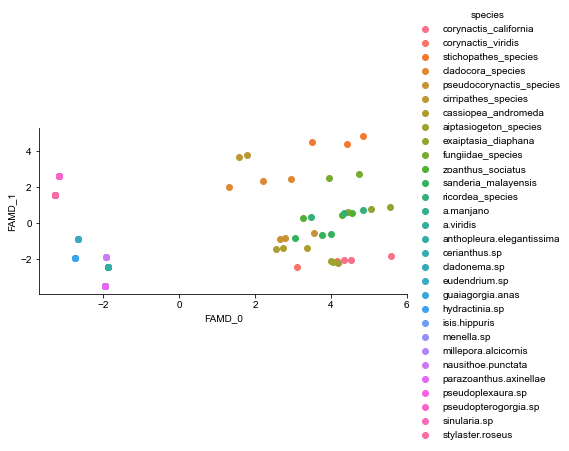

In [574]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


fg = sns.FacetGrid(data=df, hue='species', aspect=2)
fg.map(plt.scatter, 'FAMD_0', 'FAMD_1')
ax=getattr(fg, 'ax')

fg.add_legend()

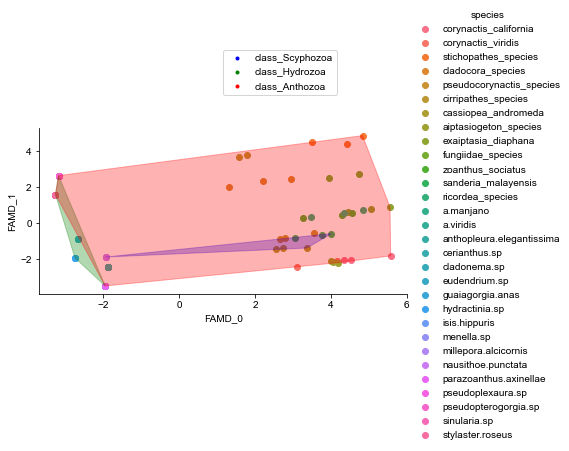

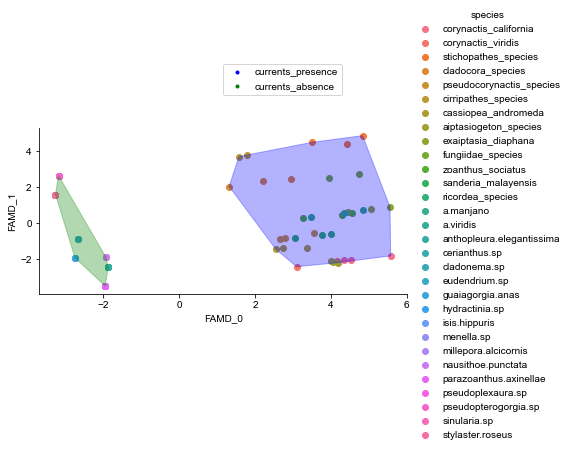

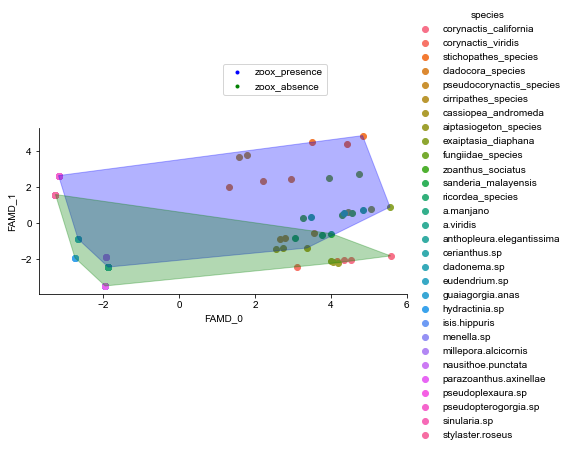

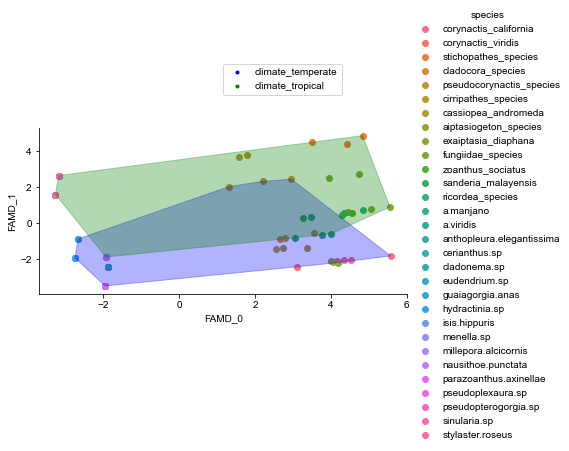

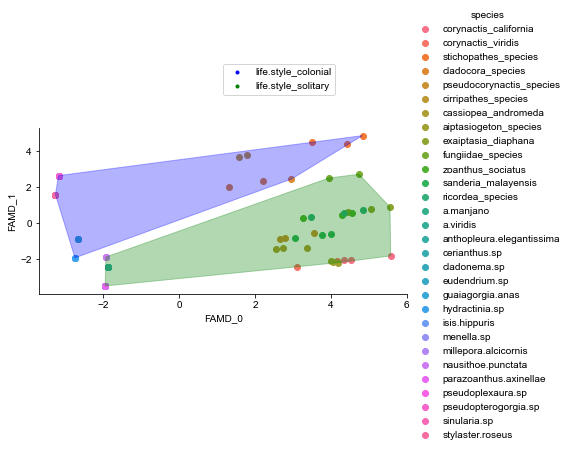

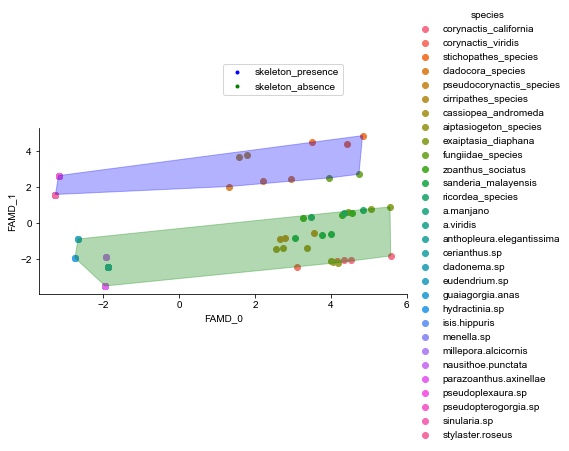

In [603]:
#fig, ax = plt.subplots()
#lines = ax.plot(data)
#ax.legend(custom_lines, ['Cold', 'Medium', 'Hot'])



#ax.fill


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np


spe_infos=[ cond for cond in life_info.columns if cond not in ('nr', 'species','family','subclass','order')]



for condition in spe_infos:
  #  fig, ax = plt.subplots()
    argument=condition



    datasets = [df[df[argument]==zoo][['FAMD_0','FAMD_1']] for zoo in set(df.loc[:,argument])]
    condition=list(set(df.loc[:,argument]))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']



    fg = sns.FacetGrid(data=df, hue='species', aspect=2)
    fg.map(plt.scatter, 'FAMD_0', 'FAMD_1')

#ax=fg.fig.get_axes()
    
    for k in range(len(datasets)):
    
        hull = ConvexHull(datasets[k])
        hull_1=pd.DataFrame(hull.points[hull.vertices]) 
        plt.fill(hull_1[0], hull_1[1], color = colors[k], alpha=0.3)

#leg2 = mlines.Line2D([], [], color=colors[1], marker='.', ls='', label=condition[1])

#define legends for 
    legend=[mlines.Line2D([], [], color=colors[n], marker='.', ls='', label=argument+'_'+condition[n]) for n in range(len(datasets))]

    plt.legend(handles=legend,loc=(.5,1.2))
    

    fg.add_legend()

In [589]:
datasets[k]

,FAMD_0,FAMD_1
key_0,,
cerianthus.sp_1,-1.952445,-3.471088
cerianthus.sp_2,-1.952445,-3.471088
cerianthus.sp_3,-1.952445,-3.471088


QhullError: QH6421 qhull internal error (qh_maxsimplex): qh.MAXwidth required for qh_maxsimplex.  Used to estimate determinate

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2023970575  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  0  Error-roundoff 3e-15  _one-merge 1.5e-14  _near-inside 7.4e-14
  Visible-distance 5.9e-15  U-max-coplanar 5.9e-15  Width-outside 1.2e-14
  _wide-facet 3.6e-14  _maxoutside 1.8e-14

A Qhull internal error has occurred.  Please send the input and output to
qhull_bug@qhull.org. If you can duplicate the error with logging ('T4z'), please
include the log file.


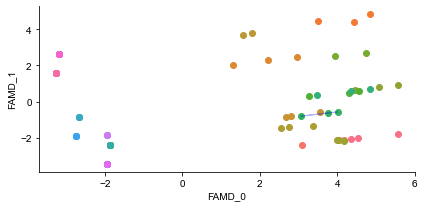

In [586]:
#fig, ax = plt.subplots()
#lines = ax.plot(data)
#ax.legend(custom_lines, ['Cold', 'Medium', 'Hot'])



#ax.fill


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np


spe_infos=[ cond for cond in life_info.columns if cond not in ('nr', 'species','family')]



for condition in spe_infos:
   # fig, ax = plt.subplots()
    argument=condition



    datasets = [df[df[argument]==zoo][['FAMD_0','FAMD_1']] for zoo in set(df.loc[:,argument])]
    condition=list(set(df.loc[:,argument]))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']



    fg = sns.FacetGrid(data=df, hue='species', aspect=2)
    fg.map(plt.scatter, 'FAMD_0', 'FAMD_1')

#ax=fg.fig.get_axes()
    
    for k in range(len(datasets)):
    
        hull = ConvexHull(datasets[k])
        hull_1=pd.DataFrame(hull.points[hull.vertices]) 
        plt.fill(hull_1[0], hull_1[1], color = colors[k], alpha=0.3)

#leg2 = mlines.Line2D([], [], color=colors[1], marker='.', ls='', label=condition[1])

#define legends for 
    legend=[mlines.Line2D([], [], color=colors[n], marker='.', ls='', label=argument+'_'+condition[n]) for n in range(len(datasets))]

    plt.legend(handles=legend,loc=(1.05,1.4))
    

    fg.add_legend()

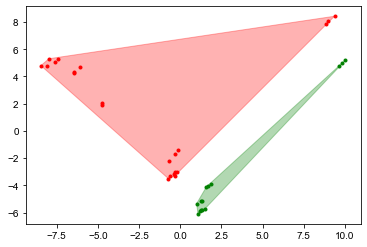

In [396]:
from scipy.spatial import ConvexHull

points = [df[df['zoox']==zoo][['FAMD_0','FAMD_1']] for zoo in set(df.loc[:,'zoox'])]
colors = ['r', 'g']
for k in range(2):
    
    hull = ConvexHull(points[k])
    hull_1=pd.DataFrame(hull.points[hull.vertices])
    plt.plot(points[k].loc[:,'FAMD_0'], points[k].loc[:,'FAMD_1'], '.', color = colors[k])
    #plt.fill(hull.vertices, hull.vertices, color = colors[k], alpha=0.3)
    plt.fill(hull_1[0], hull_1[1], color = colors[k], alpha=0.3            )
    #plt.plot(hull.vertices, hull.vertices, 'r--', lw=2)
    #plt.plot(hull.points)

In [575]:
famd.column_contributions_.style.format('{:.0%}')

component,0,1
variable,,
turns,8%,0%
sin,4%,2%
length,9%,1%
npoints,7%,0%
speedmean,7%,0%
speedvar,6%,0%
inter,4%,0%
Track Speed Max,8%,0%
Track Length,9%,1%


# Try FAMD while having random numbers instead of 0s for samples with no currents

In [604]:
import random

#### Create table for species without currents

In [734]:
#Each species was assayed thrice, value 0 assigned to all track characteristics

life_info_NO_current_random=pd.concat([pd.concat([life_info[life_info['species']==spe]]*3) for spe in [spe for spe in life_info[life_info['currents']=='absence']['species']]])
new_cols=[new_col for new_col in full_info_df.columns if new_col not in life_info_NO_current_random.columns]
#life_info_NO_current_random[new_cols]=[random.uniform(500, 10000) for n in range(len(new_cols))]


In [735]:
#Triplicate the species for triplicate reference
sample=[]
ref=0
for spe in list(np.unique(life_info_NO_current_random['species'])):
    for ref in [1,2,3]:    
        sample.append(spe+'_'+str(ref))
        
life_info_NO_current_random.index=sample     

In [736]:
range(len(life_info_NO_current_random.index))

range(0, 51)

In [787]:
#tr=pd.DataFrame([[random.uniform(0, .1) for n in range(len(new_cols)) ] for m in range(len(life_info_NO_current_random.index))])
tr=pd.DataFrame([[random.randint(100, 500) for n in range(len(new_cols)) ] for m in range(len(life_info_NO_current_random.index))]) 
for n in range(len(new_cols)):    
    life_info_NO_current_random[new_cols[n]]=tr[n].to_list()


#### Concat tbales for current and no current


In [788]:
NEW_full_info_random=pd.concat([full_info_df, life_info_NO_current_random.drop(columns=['nr'])])

In [789]:
famd = prince.FAMD(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
)

#Calculate FAMD without systematic
famd = famd.fit(NEW_full_info_random.drop(columns=['species','order','family','subclass','class']))

In [790]:
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,9.332,41.48%,41.48%
1,5.468,24.30%,65.78%


In [791]:
famd.row_coordinates(NEW_full_info_random).head()

component,0,1
010223_corynactis.california.1,3.799259,-2.113587
010223_corynactis.california.2,4.184636,-1.885168
010223_corynactis.california.3,4.174097,-1.901083
020823_corynactis.virids.3,3.867243,-2.036167
040922_stichopathes.species.1,3.677024,4.630563


In [792]:
#Assign FAMD coordinates to samples
df_1=famd.row_coordinates(NEW_full_info_random)
df_1.columns=['FAMD_0','FAMD_1']
df_1.index.name=None

df_1=pd.merge(NEW_full_info_random,df_1,on=df_1.index)

df_1.index=df_1['key_0']
df_1=df_1.drop(columns=['key_0'])

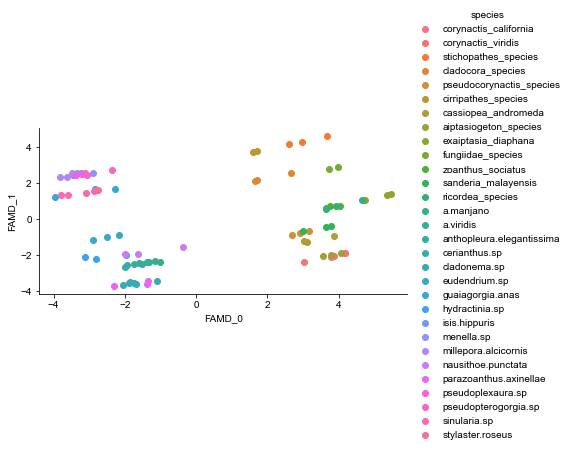

In [793]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


fg = sns.FacetGrid(data=df_1, hue='species', aspect=2)
fg.map(plt.scatter, 'FAMD_0', 'FAMD_1')
ax=getattr(fg, 'ax')

fg.add_legend()

In [794]:
famd.column_contributions_.style.format('{:.0%}')

component,0,1
variable,,
turns,8%,1%
sin,8%,1%
length,8%,1%
npoints,1%,0%
speedmean,8%,0%
speedvar,8%,0%
inter,8%,0%
Track Speed Max,0%,0%
Track Length,8%,1%


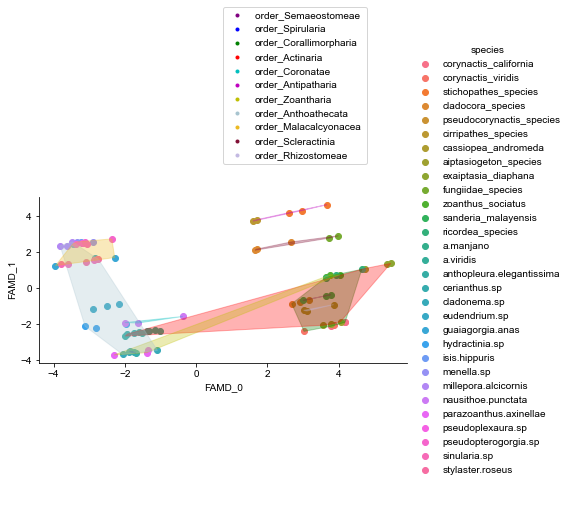

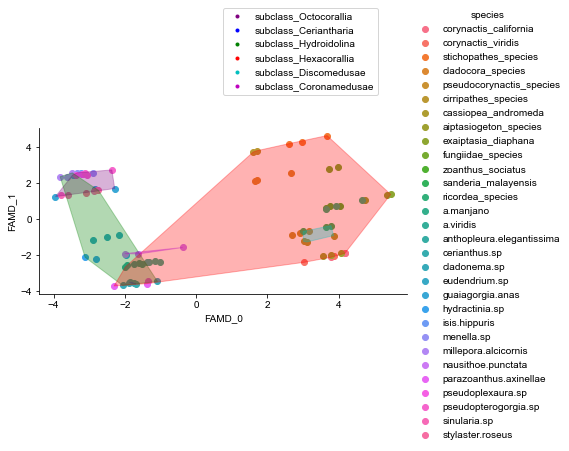

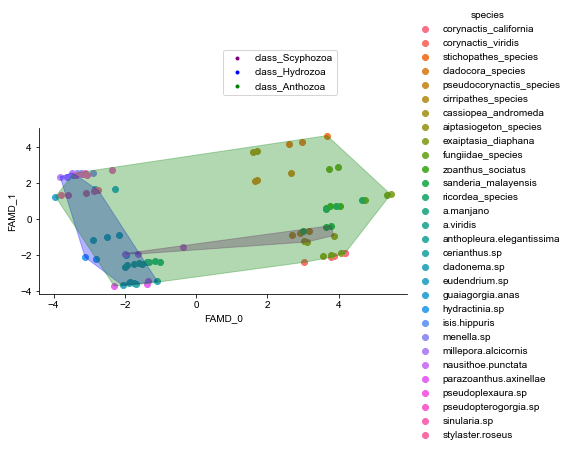

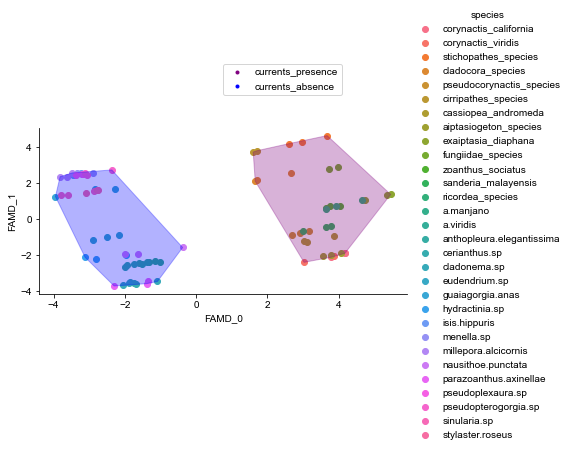

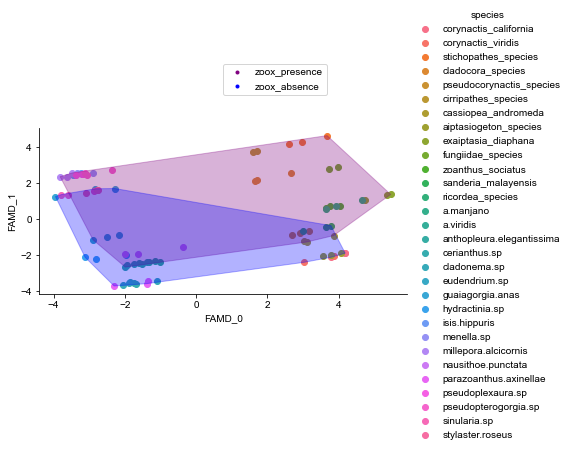

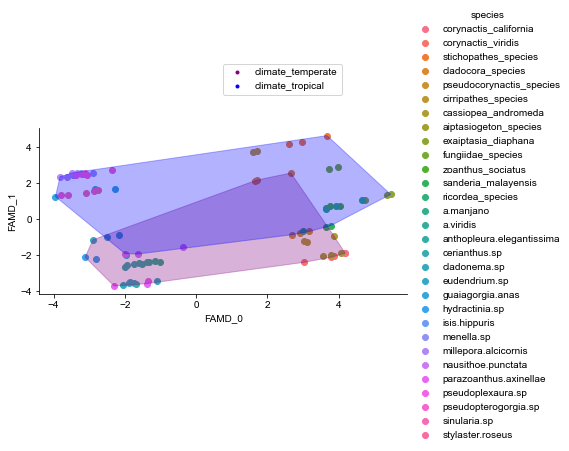

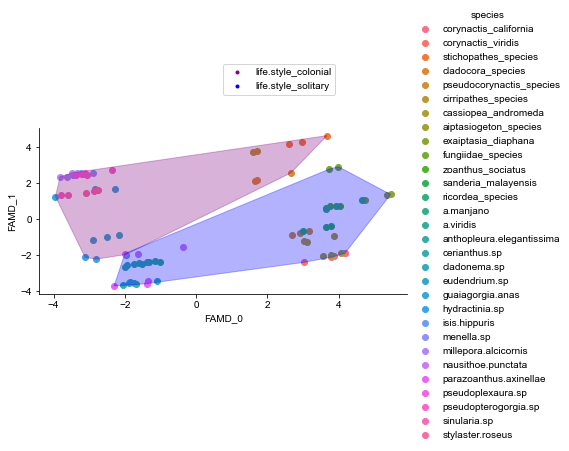

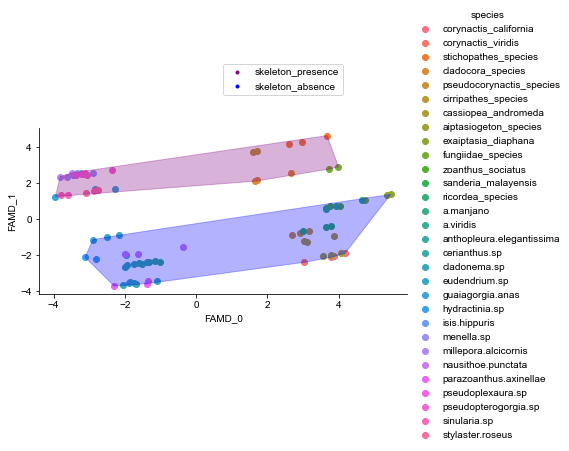

In [821]:
#fig, ax = plt.subplots()
#lines = ax.plot(data)
#ax.legend(custom_lines, ['Cold', 'Medium', 'Hot'])



#ax.fill


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np


spe_infos=[ cond for cond in life_info.columns if cond not in ('nr', 'species','family')]

colors = ['#800080','b', 'g', 'r', 'c', 'm', 'y', '#a8c4cf', '#ecb920', '#800e34', '#c3b9e2', '#a94952', '#800080','#3399ff','#d9a350','#c0ece3','#a94952','#b1a867','#e39777','#638187','#575567',
         '#e39777','#7f6e34']

for condition in spe_infos:
  #  fig, ax = plt.subplots()
    argument=condition



    datasets = [df_1[df_1[argument]==zoo][['FAMD_0','FAMD_1']] for zoo in set(df_1.loc[:,argument])]
    condition=list(set(df_1.loc[:,argument]))
    



    fg = sns.FacetGrid(data=df_1, hue='species', aspect=2)
    fg.map(plt.scatter, 'FAMD_0', 'FAMD_1')

#ax=fg.fig.get_axes()
    
    for k in range(len(datasets)):
        
        hull = ConvexHull(datasets[k])
        hull_1=pd.DataFrame(hull.points[hull.vertices]) 
        plt.fill(hull_1[0], hull_1[1], color = colors[k],
                 alpha=0.3)

#leg2 = mlines.Line2D([], [], color=colors[1], marker='.', ls='', label=condition[1])

#define legends for 
    legend=[mlines.Line2D([], [], color=colors[n], 
                          marker='.', ls='', label=argument+'_'+condition[n]) for n in range(len(datasets))]

    plt.legend(handles=legend,
        loc=(.5,1.2))
    

    fg.add_legend()

In [823]:
df_1.to_csv('151123_All_data_Cnidarians.csv')

In [ ]:
df_1.to_csv('')

In [824]:
df_1

,turns,sin,length,npoints,speedmean,speedvar,inter,Track Speed Max,Track Length,Track Displacement Length,...,family,subclass,class,currents,zoox,climate,life.style,skeleton,FAMD_0,FAMD_1
key_0,,,,,,,,,,,,,,,,,,,,,
010223_corynactis.california.1,1.577540,5.341014,1684.438776,546.085561,3.990235,11.784054,44.812834,222.138439,1684.395094,566.041502,...,Corallimorphidae,Hexacorallia,Anthozoa,presence,absence,temperate,solitary,absence,3.799259,-2.113587
010223_corynactis.california.2,1.798701,1.813248,1554.533788,374.577922,6.264477,14.651707,11.551948,304.016821,1554.469829,1024.920959,...,Corallimorphidae,Hexacorallia,Anthozoa,presence,absence,temperate,solitary,absence,4.184636,-1.885168
010223_corynactis.california.3,2.258278,2.027562,1562.911309,352.589404,5.072217,10.186182,8.814570,252.844012,1562.879625,957.304340,...,Corallimorphidae,Hexacorallia,Anthozoa,presence,absence,temperate,solitary,absence,4.174097,-1.901083
020823_corynactis.virids.3,2.209677,2.082463,1400.022870,363.822581,4.639730,11.542539,10.758065,255.050988,1400.011408,763.804947,...,Corallimorphidae,Hexacorallia,Anthozoa,presence,absence,temperate,solitary,absence,3.867243,-2.036167
040922_stichopathes.species.1,1.444444,2.892393,2151.238487,259.617284,10.255127,27.043087,11.197531,405.024392,2151.190965,1538.336316,...,Antipathidae,Hexacorallia,Anthozoa,presence,presence,tropical,colonial,presence,3.677024,4.630563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sinularia.sp_2,405.000000,349.000000,103.000000,149.000000,462.000000,184.000000,443.000000,481.000000,123.000000,201.000000,...,Sinulariidae,Octocorallia,Anthozoa,absence,absence,tropical,colonial,presence,-3.781201,1.360535
sinularia.sp_3,327.000000,167.000000,380.000000,319.000000,359.000000,213.000000,256.000000,326.000000,360.000000,160.000000,...,Sinulariidae,Octocorallia,Anthozoa,absence,absence,tropical,colonial,presence,-2.862056,1.536470
stylaster.roseus_1,212.000000,258.000000,220.000000,321.000000,241.000000,196.000000,393.000000,472.000000,443.000000,320.000000,...,Stylasteridae,Hydroidolina,Hydrozoa,absence,absence,tropical,colonial,presence,-2.742850,1.592259
